# Generative models

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Setup

In [1]:
!nvidia-smi

Sun May 11 19:20:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti     On  |   00000000:1C:00.0  On |                  N/A |
|  0%   48C    P8             17W /  130W |    1340MiB /   6144MiB |      8%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

Select the device to use

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: cuda


## Prepare the dataset

Load the dataset. The data should be placed in the `./data` directory with the following structure:

```
data
├── 00000
│   ├── 00000_0000.jpg
│       ├── 00000_0000.jpg
|   ├── 00000_00001
│       ├── 00000_0001.jpg
```

In [4]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

images = ImageFolder("data/", transform=transform)
images_count = len(images)
num_classes = len(images.classes)

print(f"Number of images: {images_count}")
print(f"Number of classes: {num_classes}")

Number of images: 39209
Number of classes: 43


Train-test split

In [5]:
from torch.utils.data import random_split

test_size = 0.2

max_train_count = None
train_count = min(int(images_count * (1 - test_size)), max_train_count if max_train_count else float('inf'))
test_count = images_count - train_count

train_ds, test_ds = random_split(images, [train_count, test_count])

batch_size = 128

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Number of training images: {len(train_dl.dataset)}")
print(f"Number of test images: {len(test_dl.dataset)}")

Number of training images: 31367
Number of test images: 7842


Show samples

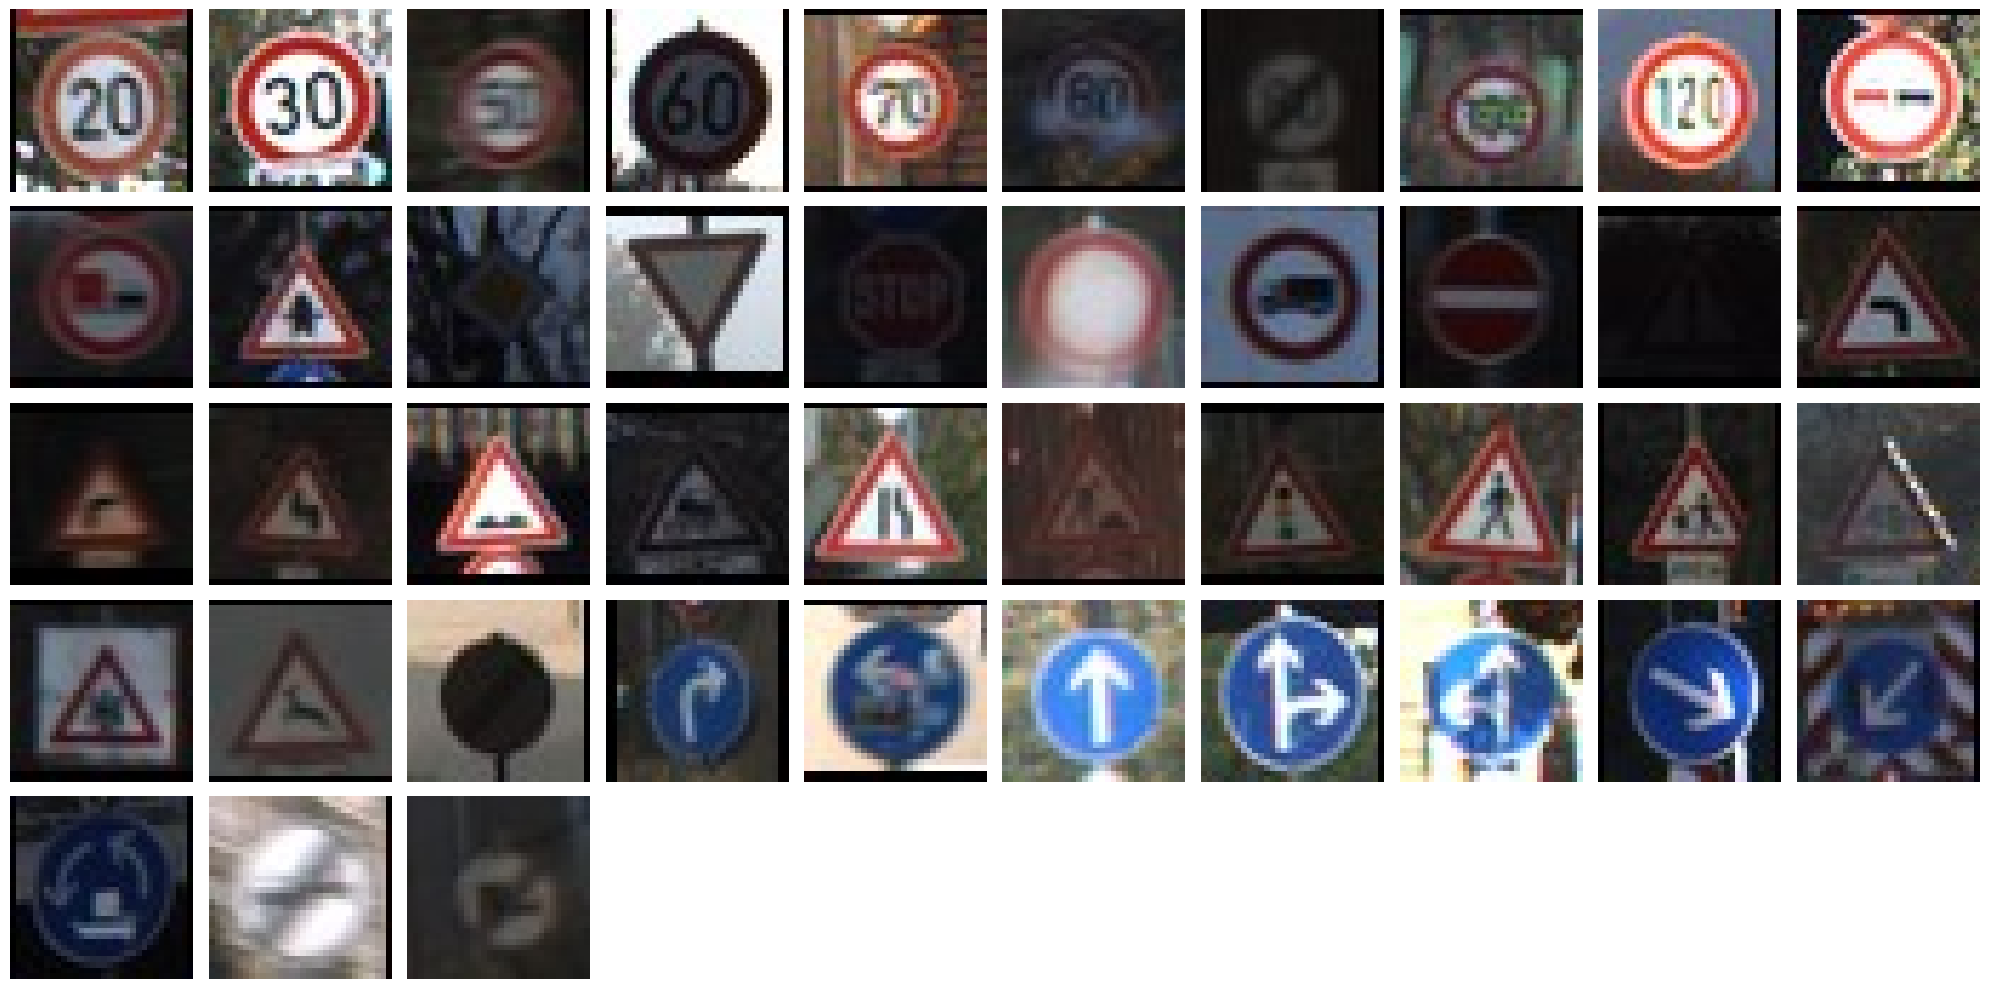

In [12]:
from collections import defaultdict
import random
import torch
from utils import denormalize_batch
from display import plot_images

class_idxs = defaultdict(list)
for idx, (_, label) in enumerate(images):
    class_idxs[label].append(idx)

sample_idxs = [random.choice(class_idxs[c]) for c in range(num_classes)]
samples = [images[i][0] for i in sample_idxs]

batch = torch.stack(samples)
batch = denormalize_batch(batch, mean=[0.5]*3, std=[0.5]*3).clamp(0, 1)
plot_images(list(batch), ncols=10)

# GAN

## Create the model

In [6]:
from gnn import Generator, Discriminator
import torch.optim as optim
import torch.nn as nn

# Models
latent_dim = 100

generator = Generator(num_classes, latent_dim=latent_dim).to(device)
discriminator = Discriminator(num_classes).to(device)

## Train the model

Setup the parameters

In [7]:
# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
adv_criterion = nn.MSELoss()
cls_criterion = nn.CrossEntropyLoss()

Perform training

Epoch 0: D_fake_acc=0.047, D_real_acc=0.963


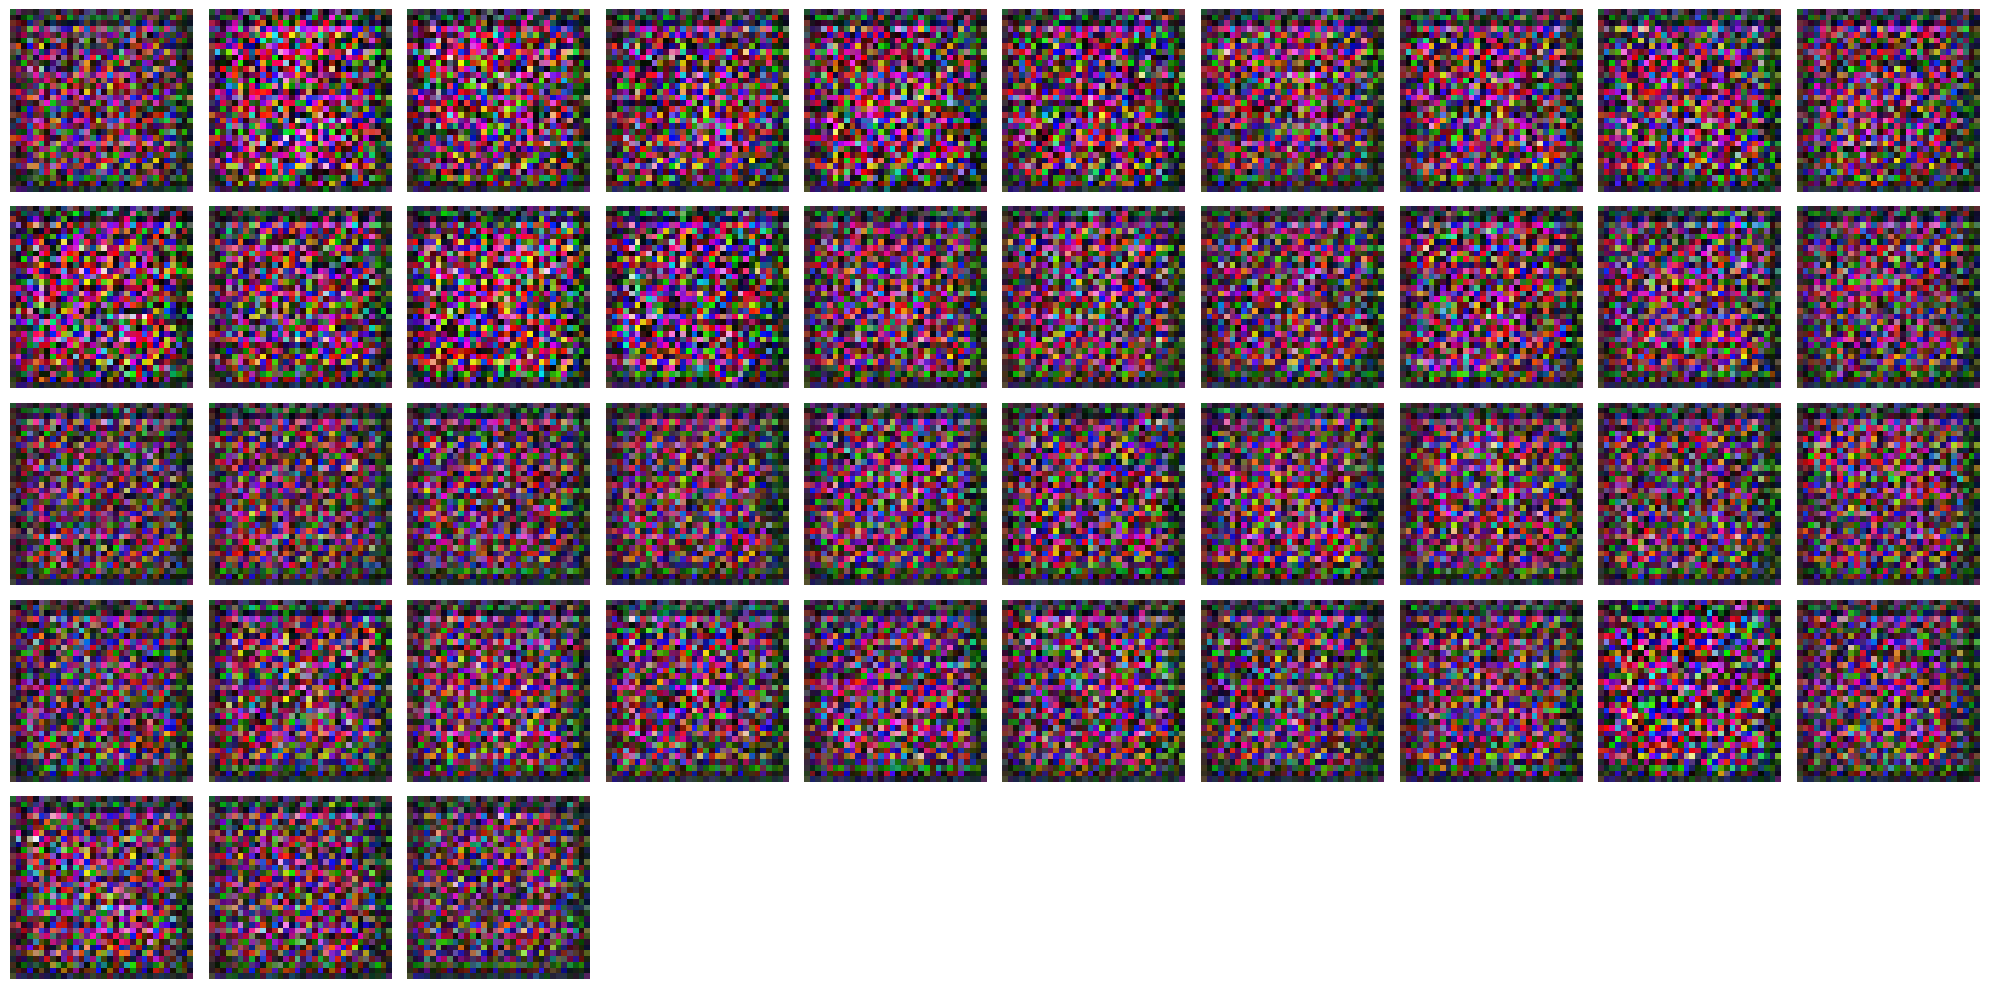

Epoch 1: D_fake_acc=0.051, D_real_acc=0.946
Epoch 2: D_fake_acc=0.070, D_real_acc=0.928
Epoch 3: D_fake_acc=0.070, D_real_acc=0.929
Epoch 4: D_fake_acc=0.101, D_real_acc=0.899
Epoch 5: D_fake_acc=0.100, D_real_acc=0.903
Epoch 6: D_fake_acc=0.121, D_real_acc=0.879
Epoch 7: D_fake_acc=0.116, D_real_acc=0.882
Epoch 8: D_fake_acc=0.114, D_real_acc=0.886
Epoch 9: D_fake_acc=0.110, D_real_acc=0.888
Epoch 10: D_fake_acc=0.118, D_real_acc=0.882


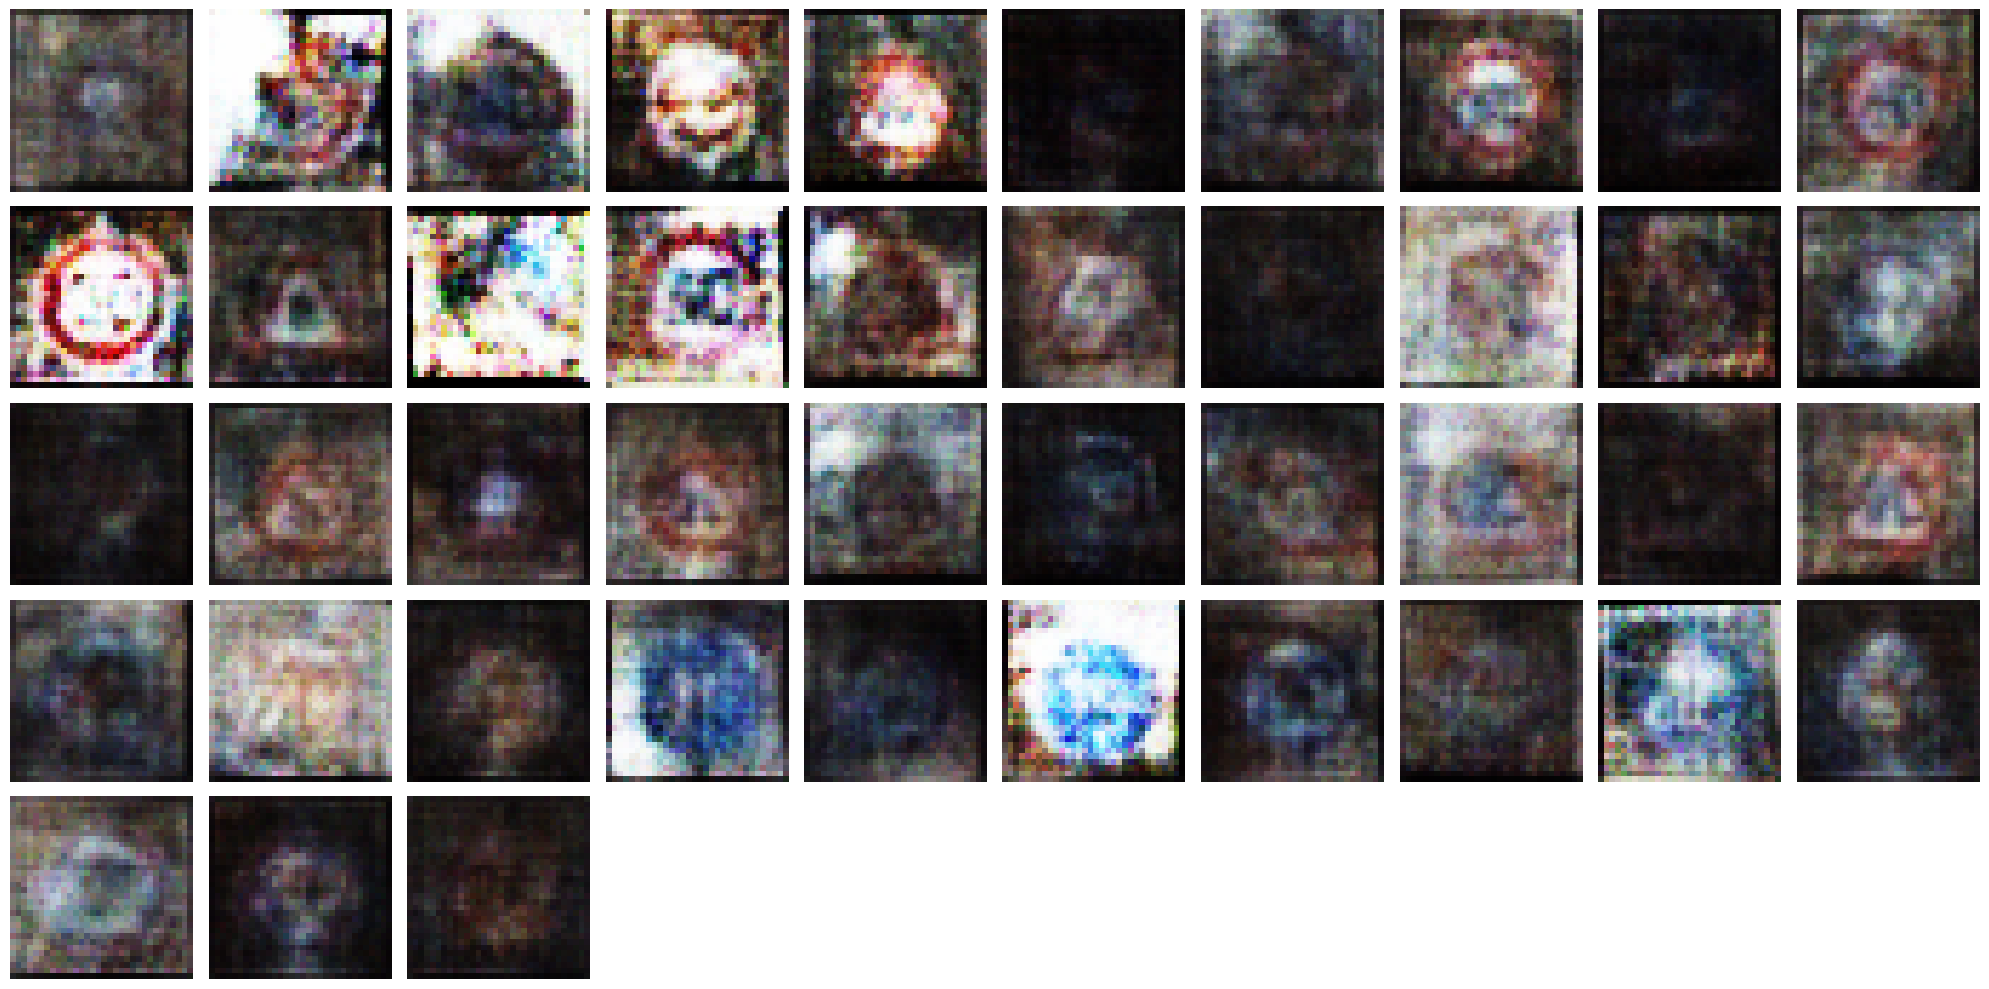

Epoch 11: D_fake_acc=0.118, D_real_acc=0.884
Epoch 12: D_fake_acc=0.122, D_real_acc=0.879
Epoch 13: D_fake_acc=0.121, D_real_acc=0.877
Epoch 14: D_fake_acc=0.125, D_real_acc=0.874
Epoch 15: D_fake_acc=0.122, D_real_acc=0.875
Epoch 16: D_fake_acc=0.127, D_real_acc=0.872
Epoch 17: D_fake_acc=0.129, D_real_acc=0.873
Epoch 18: D_fake_acc=0.133, D_real_acc=0.864
Epoch 19: D_fake_acc=0.136, D_real_acc=0.862
Epoch 20: D_fake_acc=0.135, D_real_acc=0.864


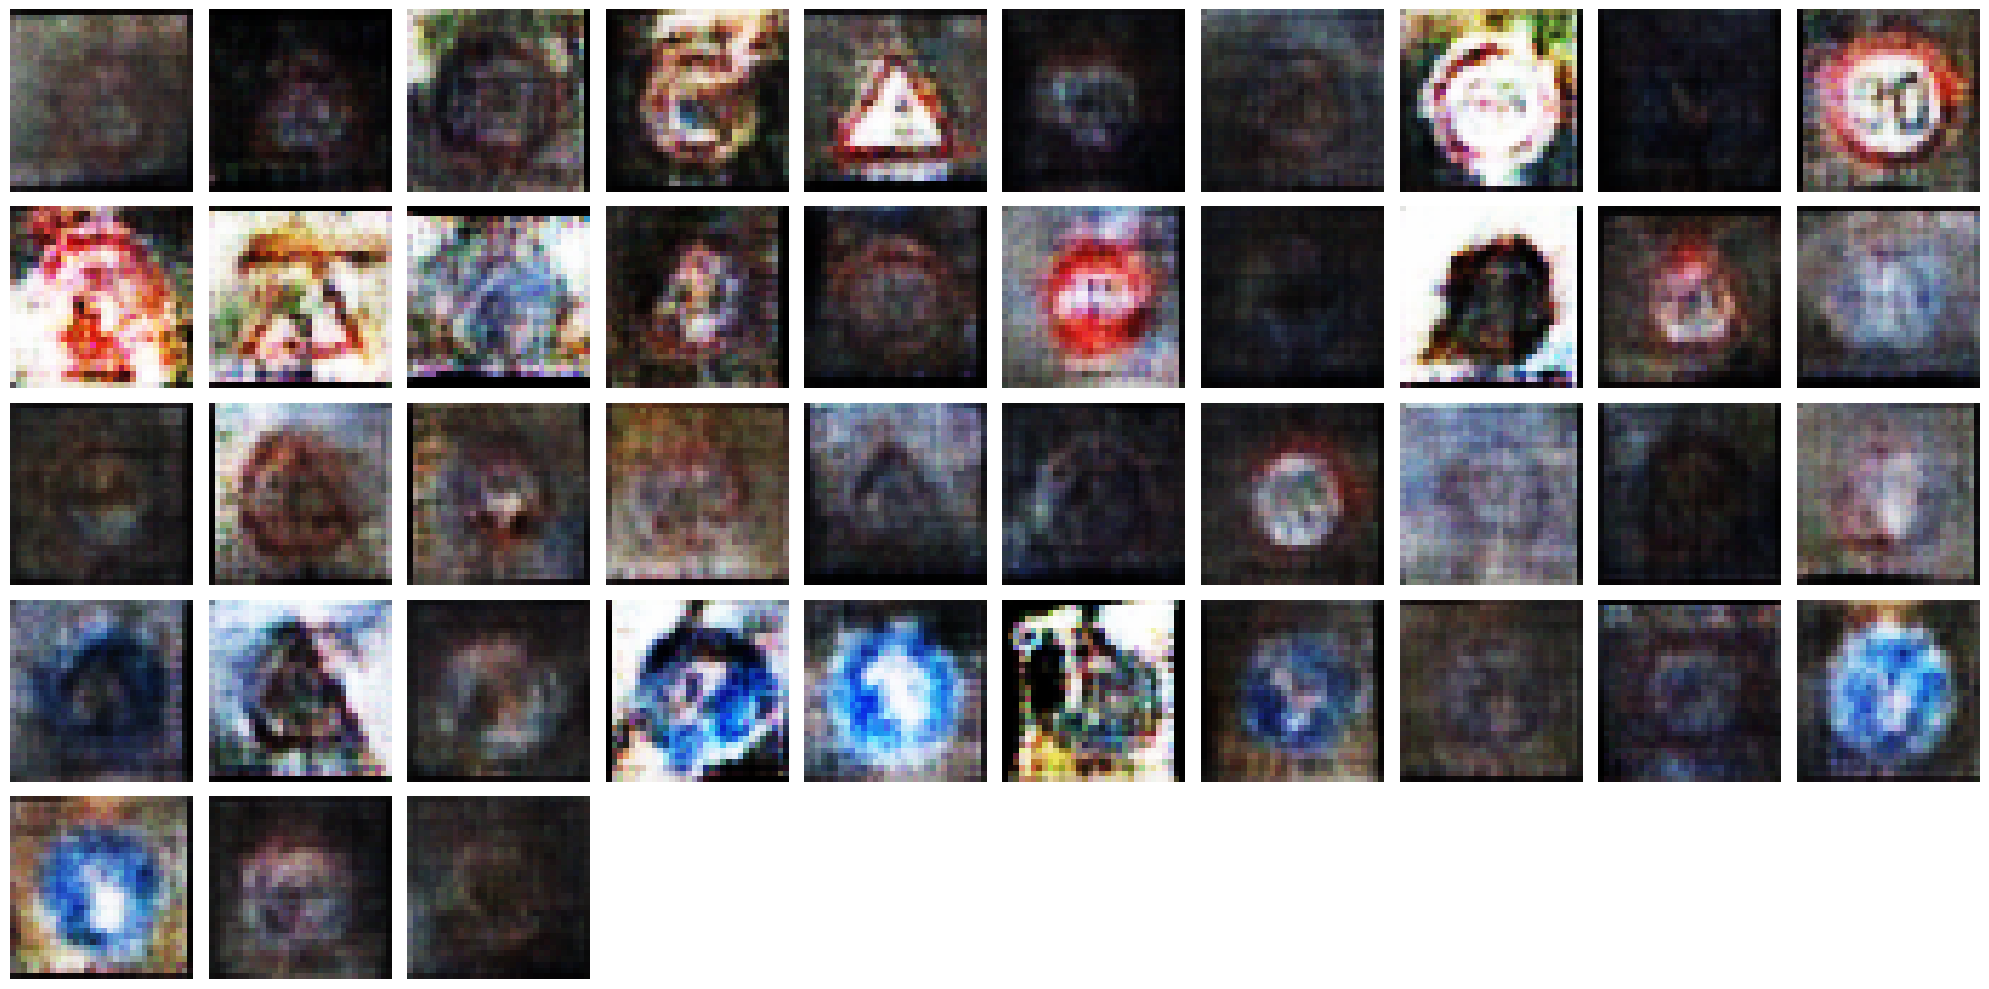

Epoch 21: D_fake_acc=0.128, D_real_acc=0.872
Epoch 22: D_fake_acc=0.133, D_real_acc=0.869
Epoch 23: D_fake_acc=0.133, D_real_acc=0.868
Epoch 24: D_fake_acc=0.130, D_real_acc=0.867
Epoch 25: D_fake_acc=0.123, D_real_acc=0.878
Epoch 26: D_fake_acc=0.125, D_real_acc=0.873
Epoch 27: D_fake_acc=0.135, D_real_acc=0.864
Epoch 28: D_fake_acc=0.139, D_real_acc=0.860
Epoch 29: D_fake_acc=0.133, D_real_acc=0.866
Epoch 30: D_fake_acc=0.136, D_real_acc=0.862


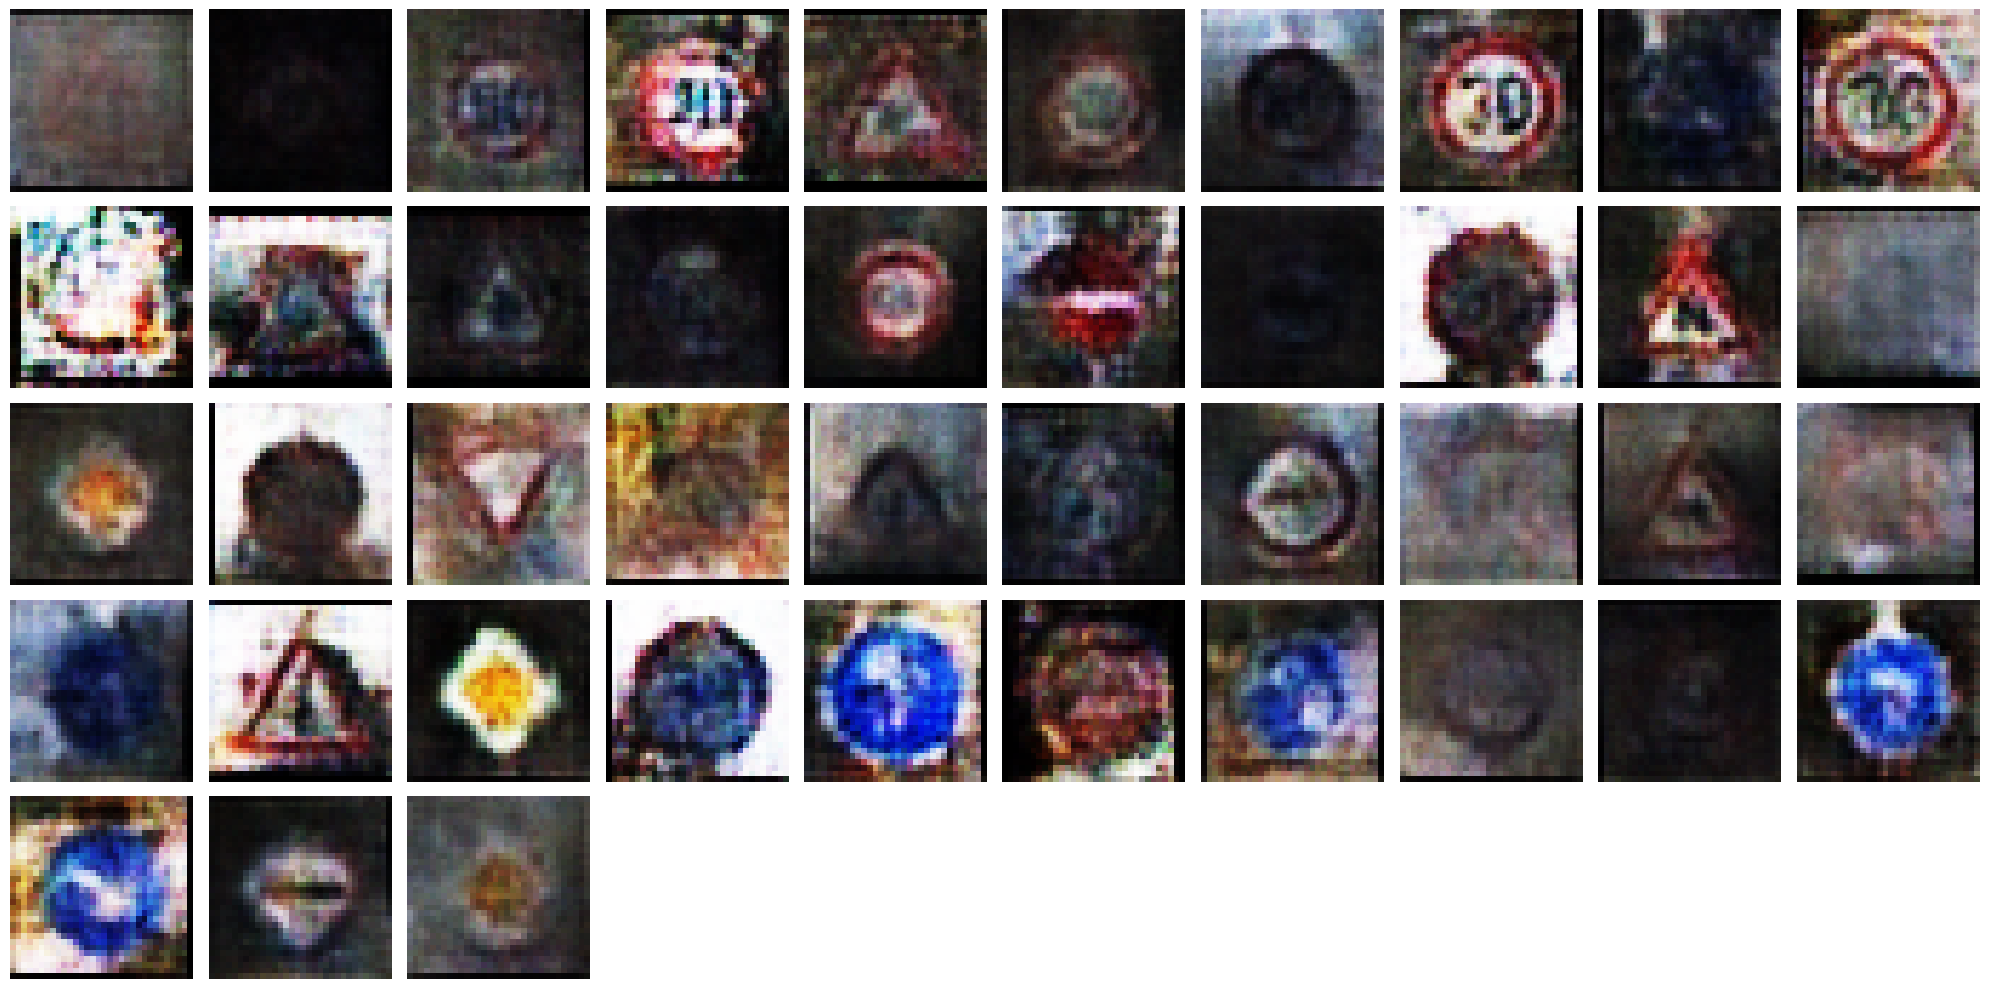

Epoch 31: D_fake_acc=0.132, D_real_acc=0.867
Epoch 32: D_fake_acc=0.137, D_real_acc=0.863
Epoch 33: D_fake_acc=0.138, D_real_acc=0.864
Epoch 34: D_fake_acc=0.135, D_real_acc=0.860
Epoch 35: D_fake_acc=0.140, D_real_acc=0.860
Epoch 36: D_fake_acc=0.145, D_real_acc=0.857
Epoch 37: D_fake_acc=0.136, D_real_acc=0.861
Epoch 38: D_fake_acc=0.140, D_real_acc=0.860
Epoch 39: D_fake_acc=0.133, D_real_acc=0.865
Epoch 40: D_fake_acc=0.132, D_real_acc=0.867


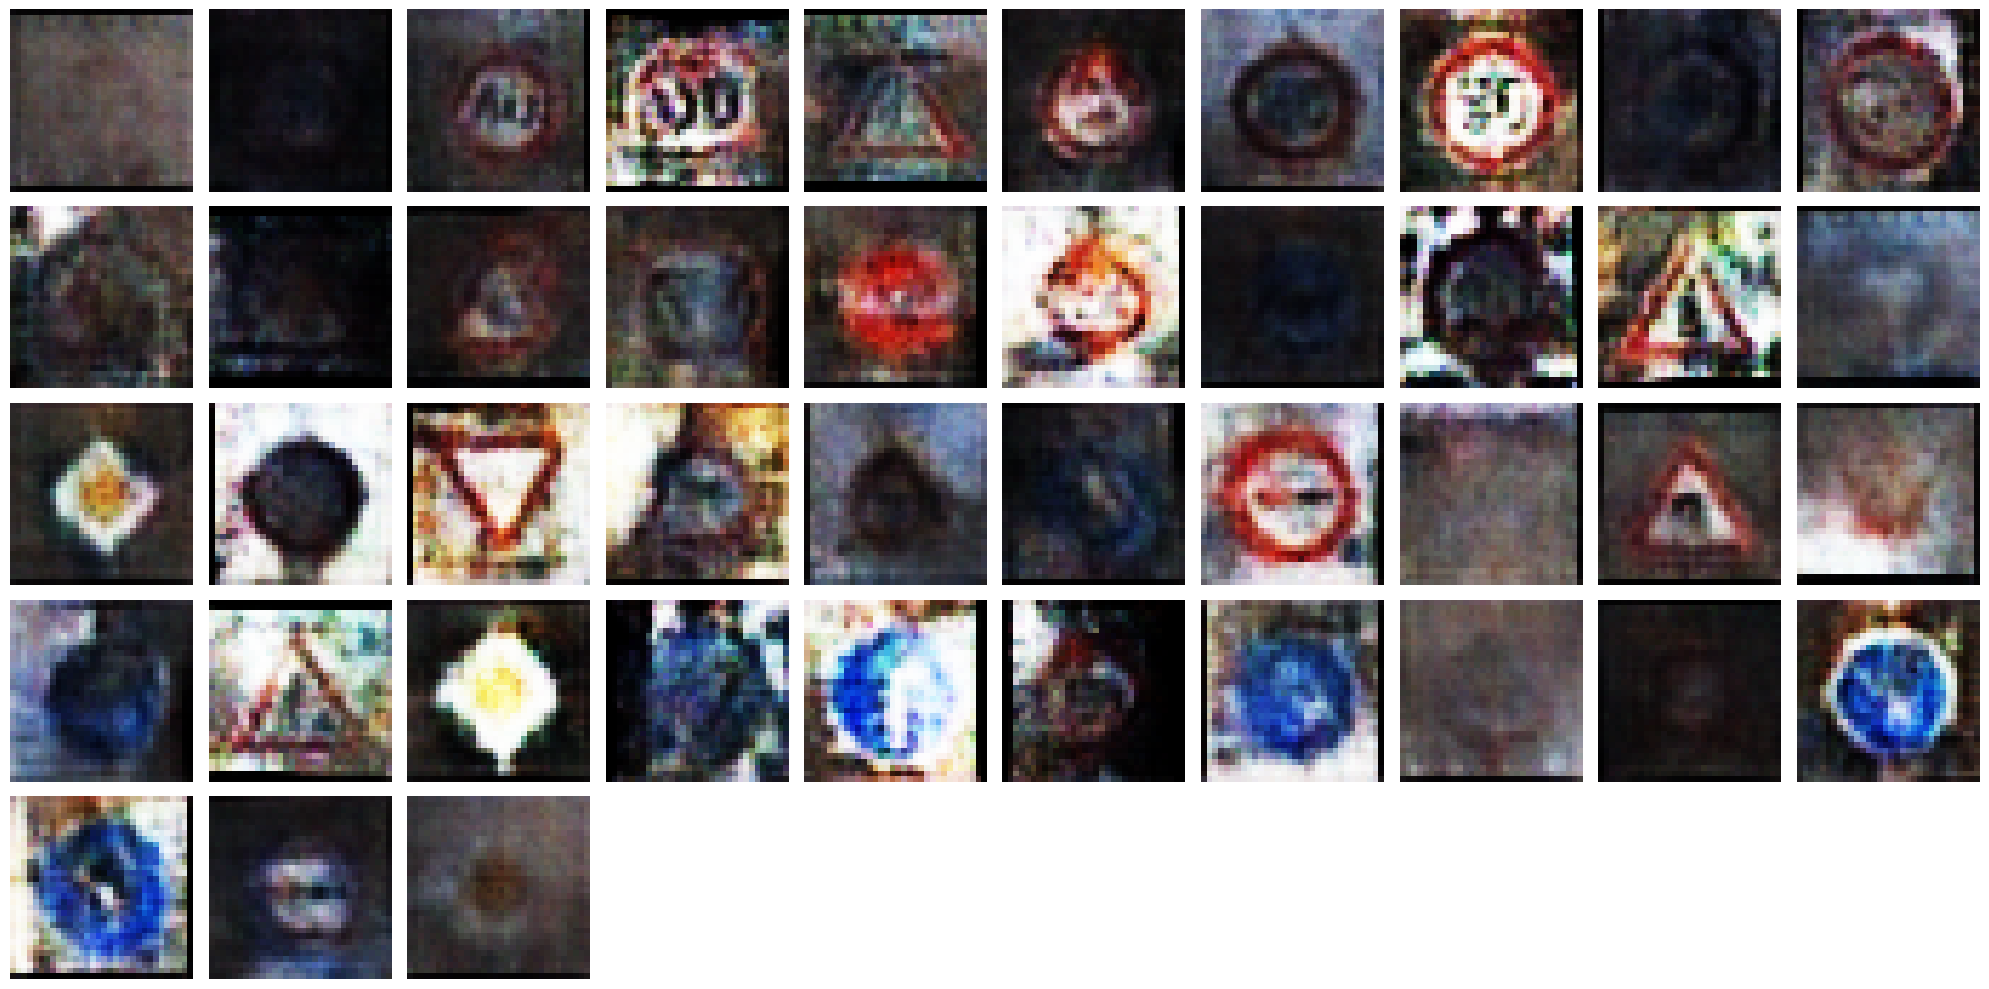

Epoch 41: D_fake_acc=0.130, D_real_acc=0.871
Epoch 42: D_fake_acc=0.131, D_real_acc=0.868
Epoch 43: D_fake_acc=0.135, D_real_acc=0.862
Epoch 44: D_fake_acc=0.143, D_real_acc=0.858
Epoch 45: D_fake_acc=0.141, D_real_acc=0.857
Epoch 46: D_fake_acc=0.140, D_real_acc=0.861
Epoch 47: D_fake_acc=0.150, D_real_acc=0.848
Epoch 48: D_fake_acc=0.154, D_real_acc=0.847
Epoch 49: D_fake_acc=0.143, D_real_acc=0.860
Epoch 50: D_fake_acc=0.144, D_real_acc=0.854


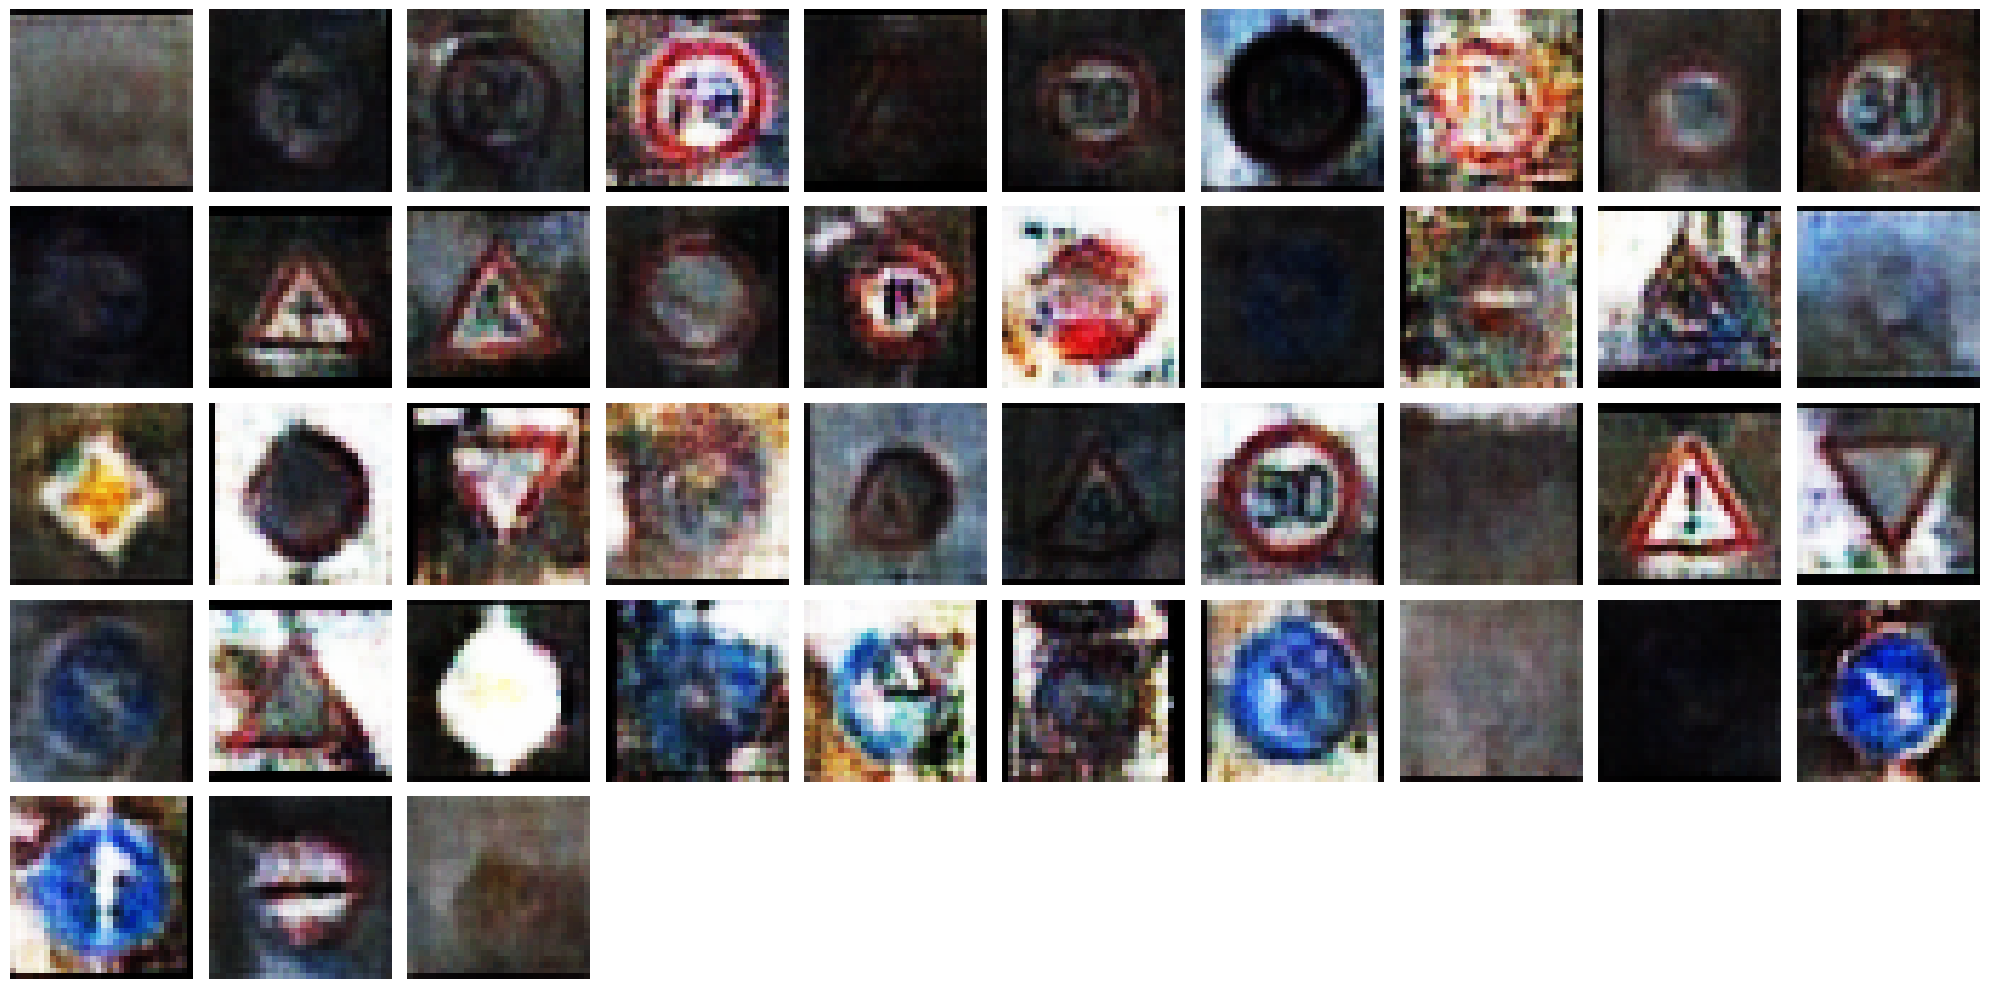

Epoch 51: D_fake_acc=0.140, D_real_acc=0.856
Epoch 52: D_fake_acc=0.146, D_real_acc=0.857
Epoch 53: D_fake_acc=0.140, D_real_acc=0.858
Epoch 54: D_fake_acc=0.155, D_real_acc=0.844
Epoch 55: D_fake_acc=0.160, D_real_acc=0.835
Epoch 56: D_fake_acc=0.176, D_real_acc=0.830
Epoch 57: D_fake_acc=0.160, D_real_acc=0.841
Epoch 58: D_fake_acc=0.157, D_real_acc=0.839
Epoch 59: D_fake_acc=0.161, D_real_acc=0.841
Epoch 60: D_fake_acc=0.164, D_real_acc=0.835


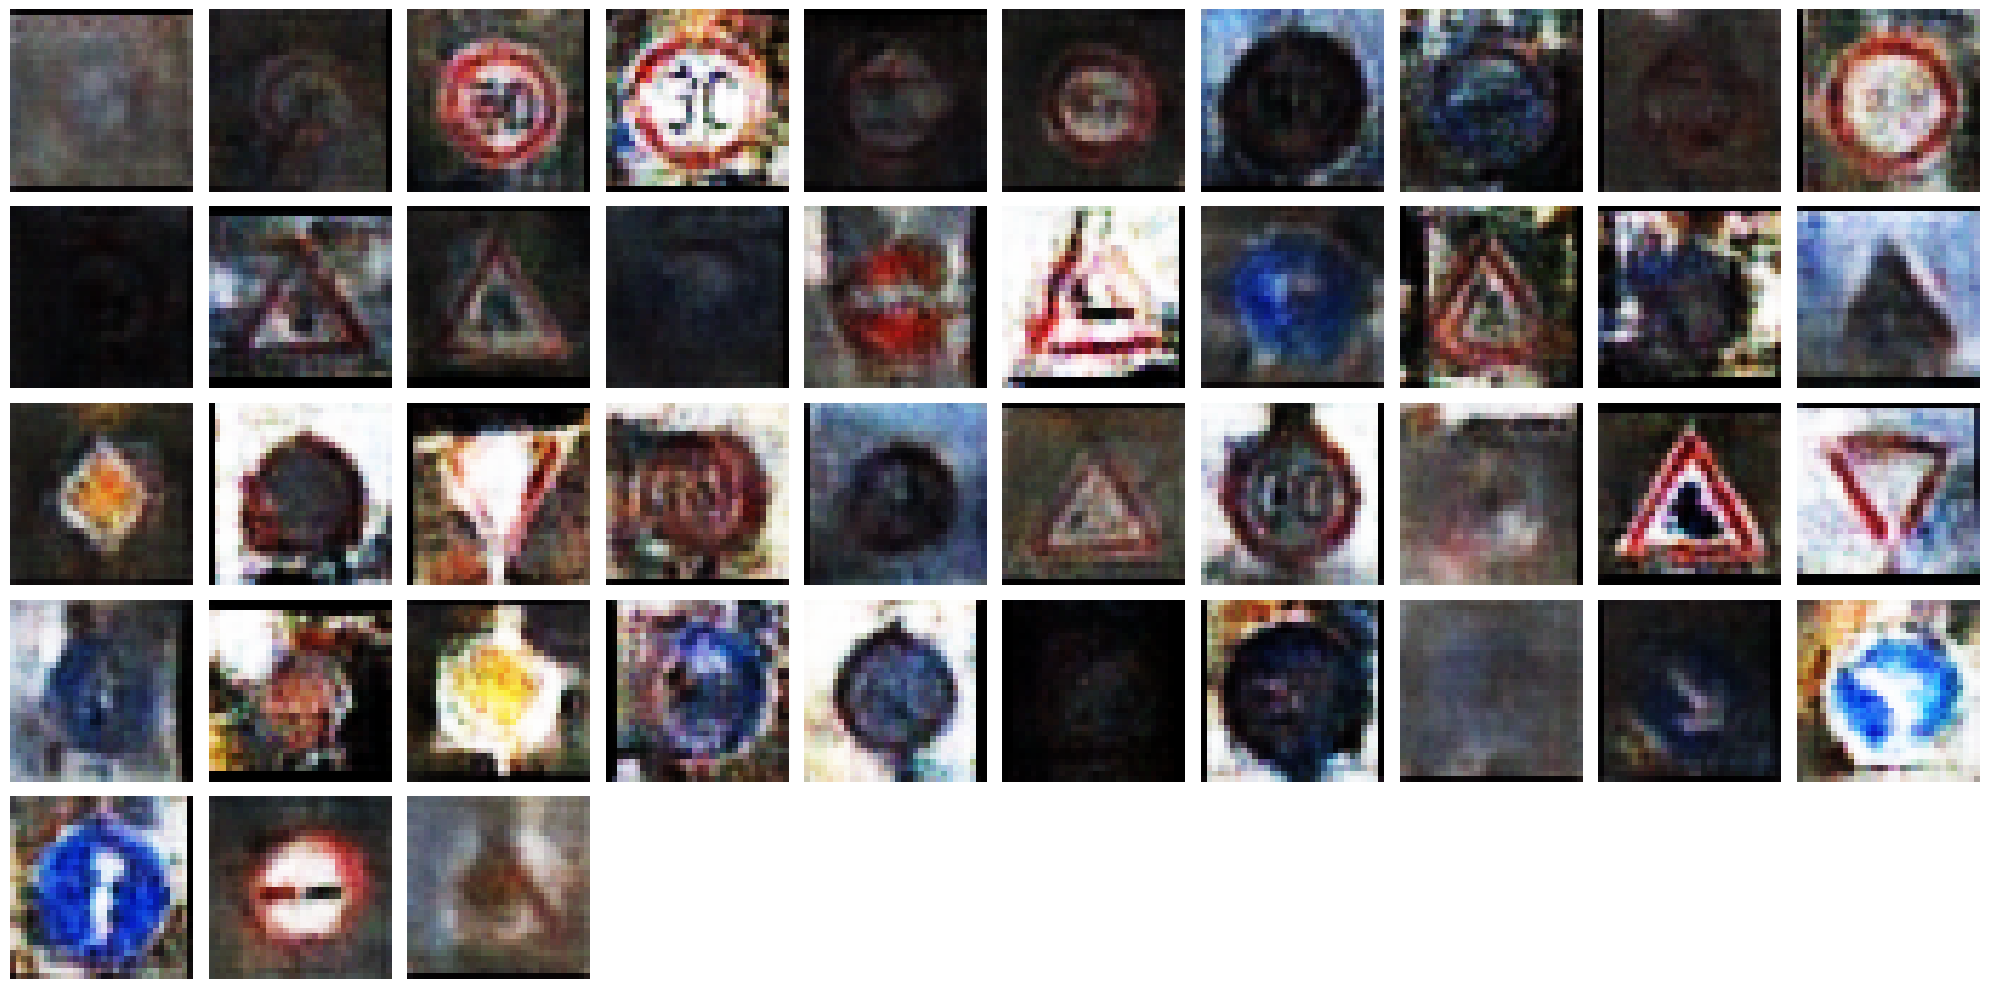

Epoch 61: D_fake_acc=0.148, D_real_acc=0.849
Epoch 62: D_fake_acc=0.149, D_real_acc=0.853
Epoch 63: D_fake_acc=0.158, D_real_acc=0.840
Epoch 64: D_fake_acc=0.153, D_real_acc=0.847
Epoch 65: D_fake_acc=0.152, D_real_acc=0.846
Epoch 66: D_fake_acc=0.150, D_real_acc=0.855
Epoch 67: D_fake_acc=0.143, D_real_acc=0.854
Epoch 68: D_fake_acc=0.140, D_real_acc=0.859
Epoch 69: D_fake_acc=0.148, D_real_acc=0.855
Epoch 70: D_fake_acc=0.158, D_real_acc=0.839


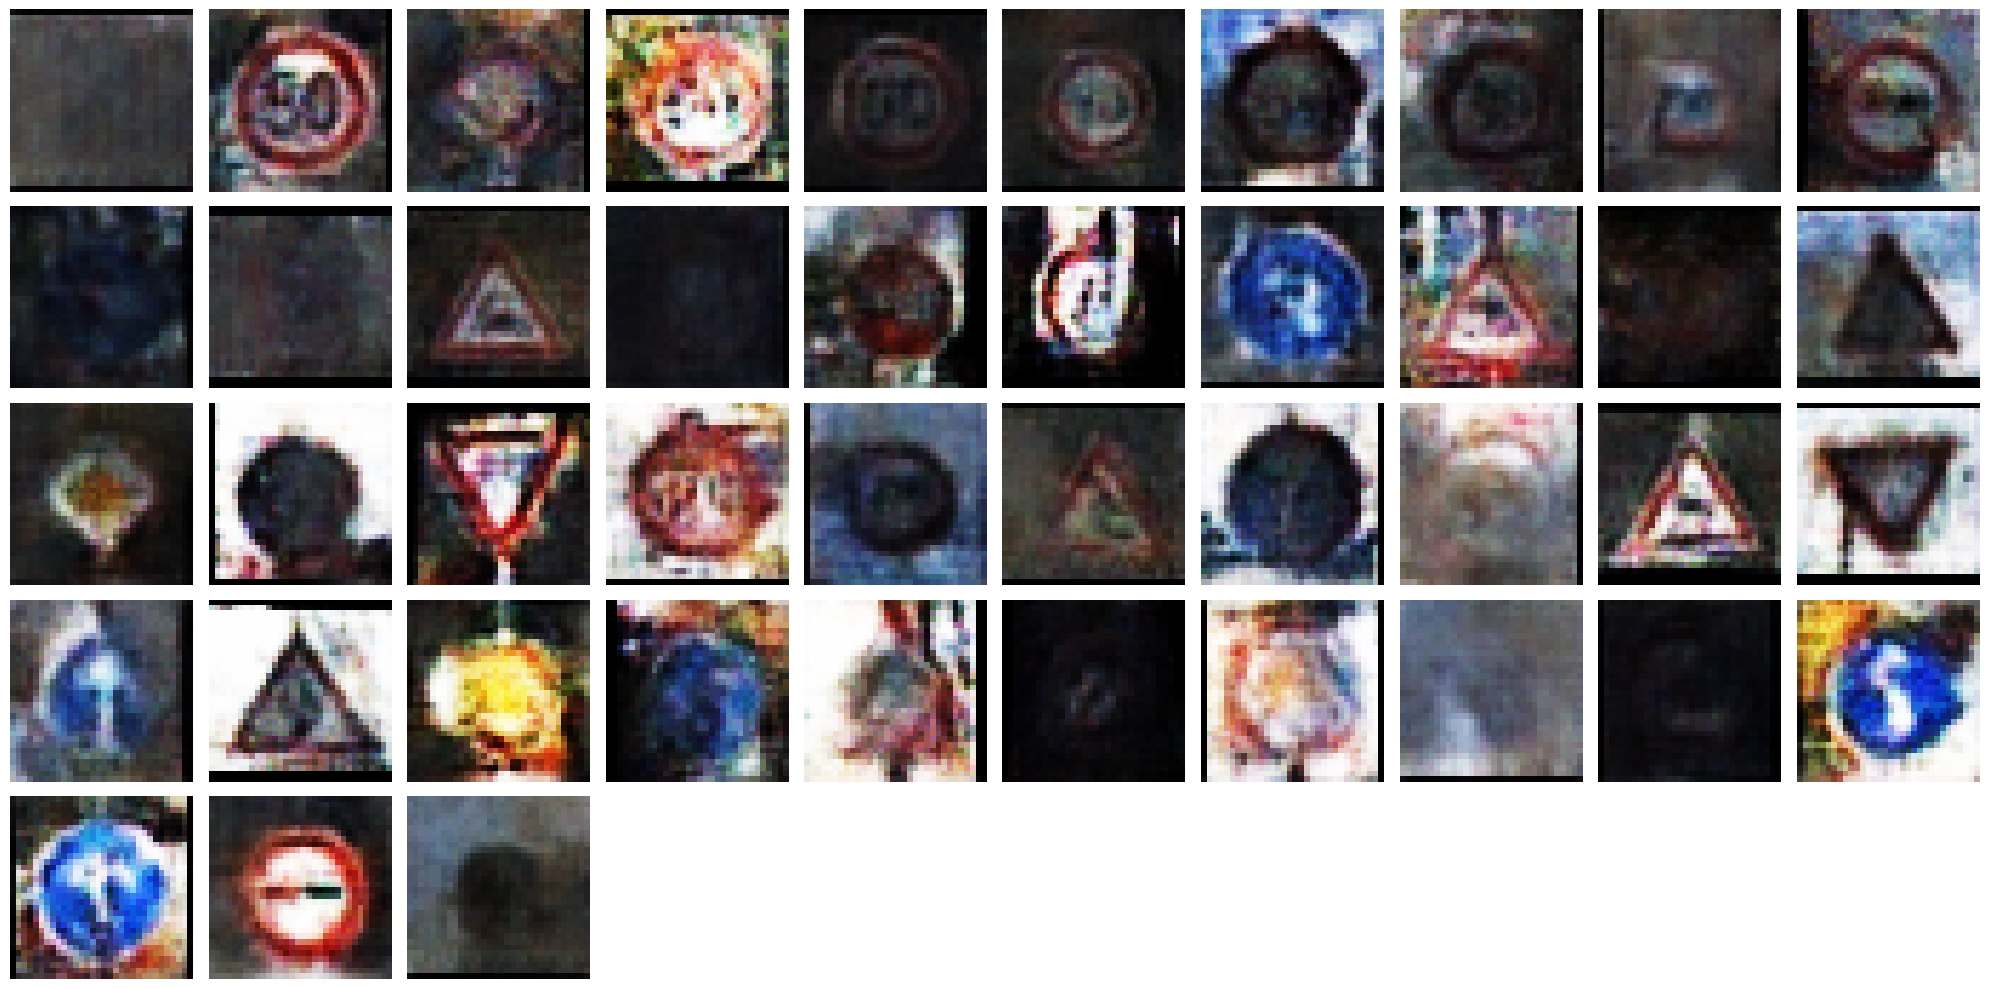

Epoch 71: D_fake_acc=0.146, D_real_acc=0.854
Epoch 72: D_fake_acc=0.155, D_real_acc=0.847
Epoch 73: D_fake_acc=0.151, D_real_acc=0.848
Epoch 74: D_fake_acc=0.153, D_real_acc=0.847
Epoch 75: D_fake_acc=0.153, D_real_acc=0.845
Epoch 76: D_fake_acc=0.156, D_real_acc=0.846
Epoch 77: D_fake_acc=0.153, D_real_acc=0.845
Epoch 78: D_fake_acc=0.160, D_real_acc=0.843
Epoch 79: D_fake_acc=0.161, D_real_acc=0.836
Epoch 80: D_fake_acc=0.167, D_real_acc=0.833


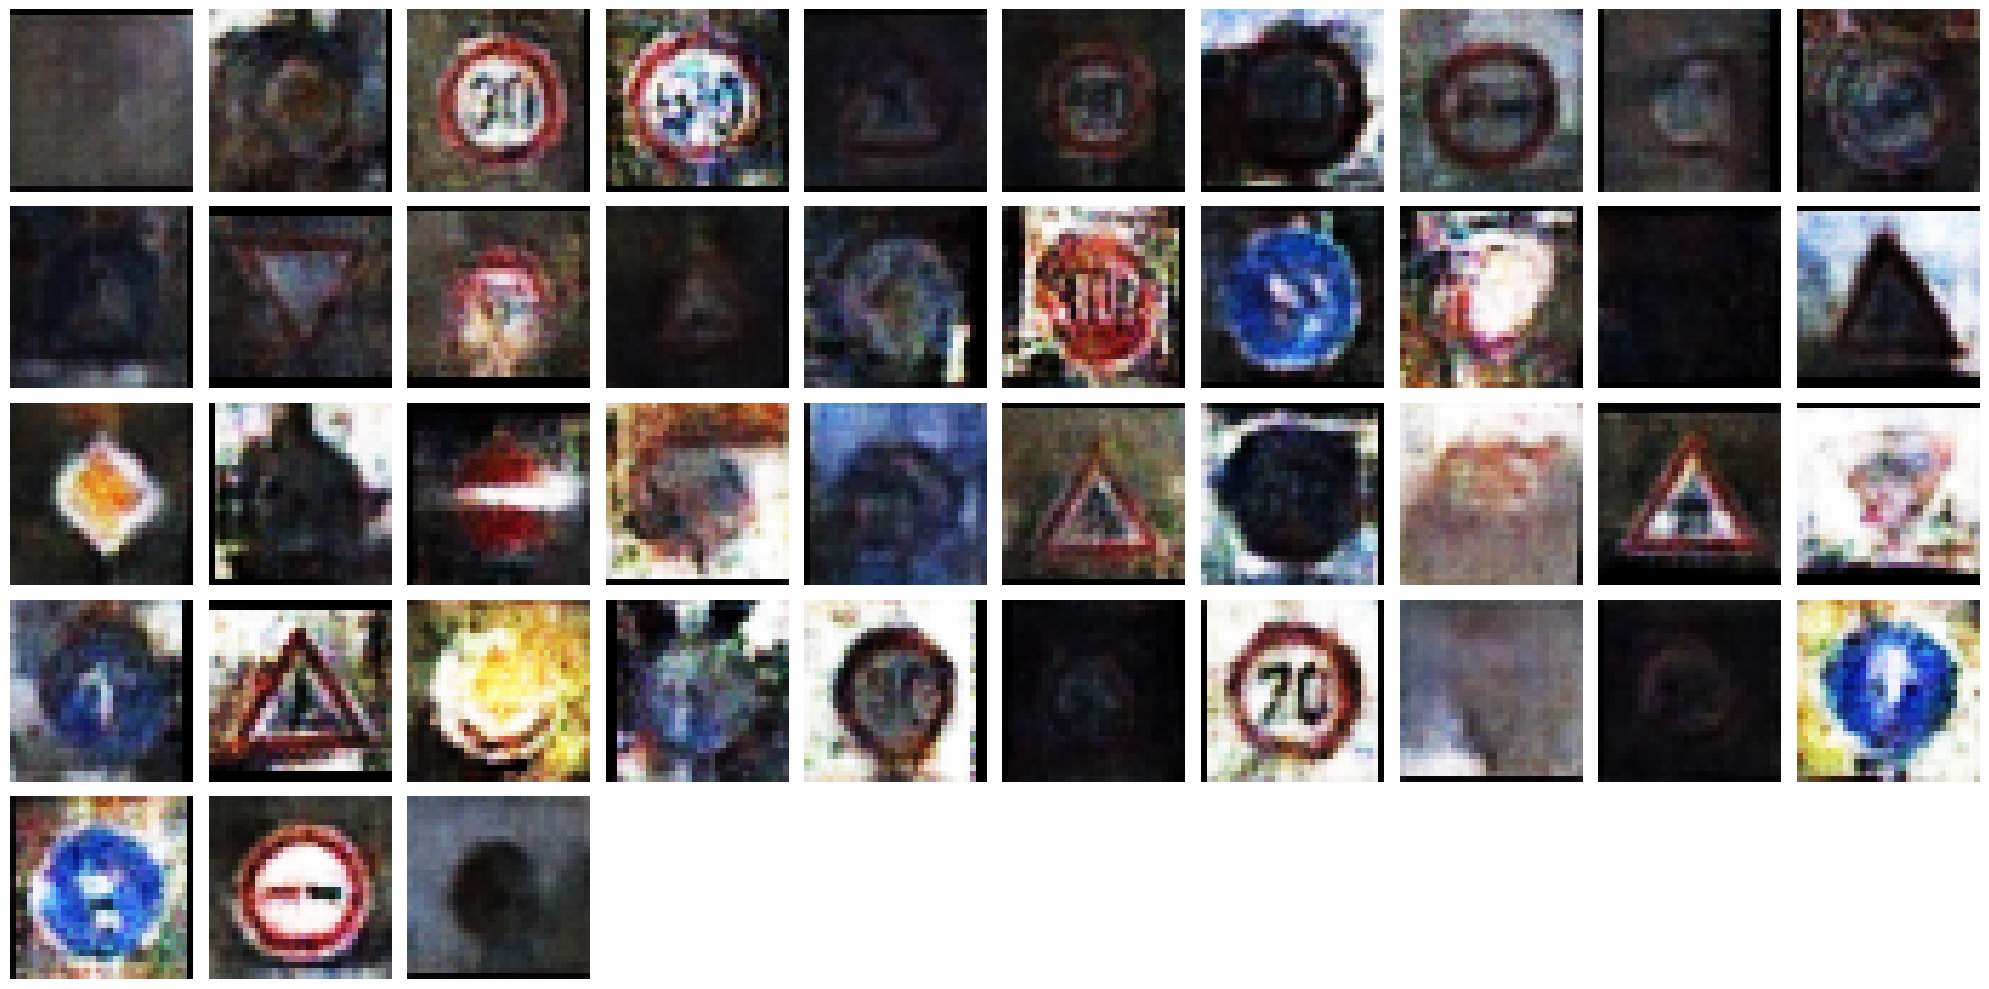

Epoch 81: D_fake_acc=0.155, D_real_acc=0.844
Epoch 82: D_fake_acc=0.157, D_real_acc=0.843
Epoch 83: D_fake_acc=0.163, D_real_acc=0.839
Epoch 84: D_fake_acc=0.158, D_real_acc=0.838
Epoch 85: D_fake_acc=0.170, D_real_acc=0.829
Epoch 86: D_fake_acc=0.171, D_real_acc=0.832
Epoch 87: D_fake_acc=0.163, D_real_acc=0.831
Epoch 88: D_fake_acc=0.158, D_real_acc=0.841
Epoch 89: D_fake_acc=0.159, D_real_acc=0.845
Epoch 90: D_fake_acc=0.164, D_real_acc=0.837


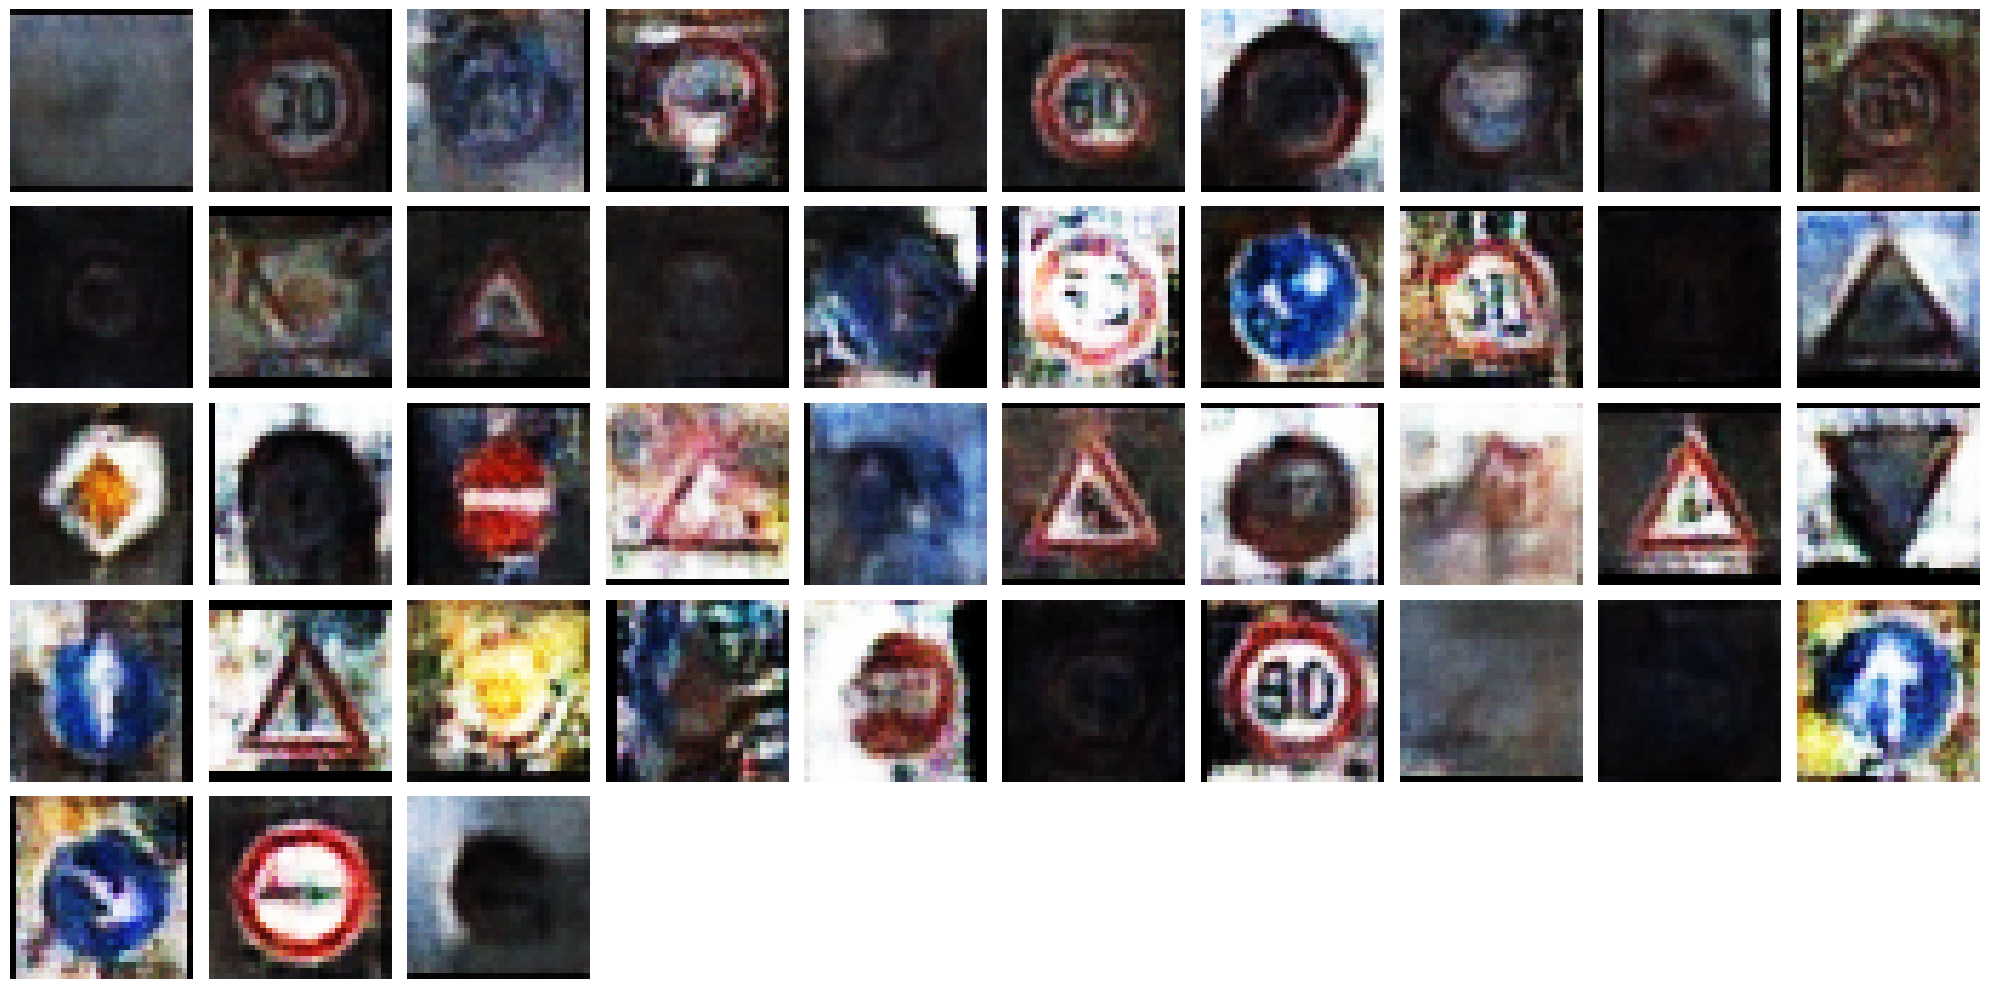

Epoch 91: D_fake_acc=0.161, D_real_acc=0.838
Epoch 92: D_fake_acc=0.167, D_real_acc=0.831
Epoch 93: D_fake_acc=0.157, D_real_acc=0.843
Epoch 94: D_fake_acc=0.146, D_real_acc=0.851
Epoch 95: D_fake_acc=0.146, D_real_acc=0.852
Epoch 96: D_fake_acc=0.162, D_real_acc=0.839
Epoch 97: D_fake_acc=0.161, D_real_acc=0.840
Epoch 98: D_fake_acc=0.161, D_real_acc=0.839
Epoch 99: D_fake_acc=0.158, D_real_acc=0.841


{'G_losses': [4.171402454376221,
  4.077482223510742,
  4.177285194396973,
  4.500638961791992,
  4.673350811004639,
  4.385162353515625,
  4.003451347351074,
  3.4220943450927734,
  3.286179542541504,
  3.240622043609619,
  3.195723295211792,
  3.0115694999694824,
  3.0284667015075684,
  2.919039011001587,
  2.9104886054992676,
  3.0554347038269043,
  3.079179525375366,
  2.8611512184143066,
  2.584455966949463,
  2.4861700534820557,
  2.384936809539795,
  2.442227363586426,
  2.4216549396514893,
  2.460418701171875,
  2.668855667114258,
  2.5012080669403076,
  2.677299976348877,
  2.5722463130950928,
  1.9911625385284424,
  2.422478675842285,
  2.152083396911621,
  2.0267953872680664,
  2.1342506408691406,
  2.249418258666992,
  2.479483127593994,
  2.2701079845428467,
  2.225889205932617,
  1.9584516286849976,
  2.162729024887085,
  2.057080030441284,
  2.1964776515960693,
  2.196950912475586,
  2.0568621158599854,
  1.9371474981307983,
  2.1270904541015625,
  2.1588780879974365,
  

In [8]:
from gnn import Trainer as GNNTrainer

gnn_trainer = GNNTrainer(num_classes, adversarial_criterion=adv_criterion, classification_criterion=cls_criterion, latent_dim=latent_dim, device=device)
gnn_trainer.set_generator(generator, generator_optimizer, generator_scheduler)
gnn_trainer.set_discriminator(discriminator, discriminator_optimizer, discriminator_scheduler)

# Training
gnn_trainer.fit(train_dl, num_epochs=100)

## Evaluate the model

In [11]:
# Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from pytorch_fid.inception import InceptionV3

block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
incep = InceptionV3([block_idx]).to(device).eval()


def get_activations_batch(x: torch.Tensor) -> np.ndarray:
    # resize to 299×299
    x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
    with torch.no_grad():
        feat_map = incep(x.to(device))[0]       # [B,2048,1,1]
    feats = feat_map.view(feat_map.size(0), -1)  # [B,2048]
    return feats.cpu().numpy()


# 2) collect real‑image features
real_feats_list = []
for real_imgs, _ in test_dl:
    # denorm into [0,1]
    real = denormalize_batch(real_imgs, [0.5]*3, [0.5]*3).clamp(0, 1)
    real_feats_list.append(get_activations_batch(real))
    print(f"Processed {len(real_feats_list)} batches of real images", end='\r')

# stack into one array of shape [N,2048]
real_feats = np.vstack(real_feats_list)
N = real_feats.shape[0]

# 3) collect fake‑image features (same N)
fake_feats_list = []
samples_collected = 0
while samples_collected < N:
    batch_size = test_dl.batch_size
    noise = torch.randn(batch_size, latent_dim, device=device)
    fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
    fake_norm = generator(noise, fake_labels)                          # in [–1,1]
    fake = denormalize_batch(fake_norm, [0.5]*3, [0.5]*3).clamp(0, 1)
    arr = get_activations_batch(fake)
    fake_feats_list.append(arr)
    samples_collected += arr.shape[0]
    print(f"Processed {len(fake_feats_list)} batches of fake images", end='\r')

fake_feats = np.vstack(fake_feats_list)[:N]  # trim to exactly N

print("")

fid_value = calculate_frechet_distance(real_feats, fake_feats)
print(f"FID = {fid_value:.3f}")

# VAE

## Create model

In [6]:
from gnn import VariationalAutoencoder as VAE
from gnn import VAETrainer
import torch.optim as optim
import torch.nn as nn


IMG_CHANNELS = 3
# IMG_SIZE = 32 # default in vae class
latent_dim = 100

# model
vae_model = VAE(IMG_CHANNELS, latent_dim=latent_dim).to(device)

# optimizers
vae_optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.0001)
vae_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=vae_optimizer, gamma=0.99)

# trainer
vae_trainer = VAETrainer(
    vae_model=vae_model,
    optimizer=vae_optimizer,
    scheduler=vae_scheduler,
    latent_dim=latent_dim,
    device=device
)

## Training

Epoch 1/1: Total Loss: 156.6297, Recon Loss: 115.4323, KLD Loss: 41.1974


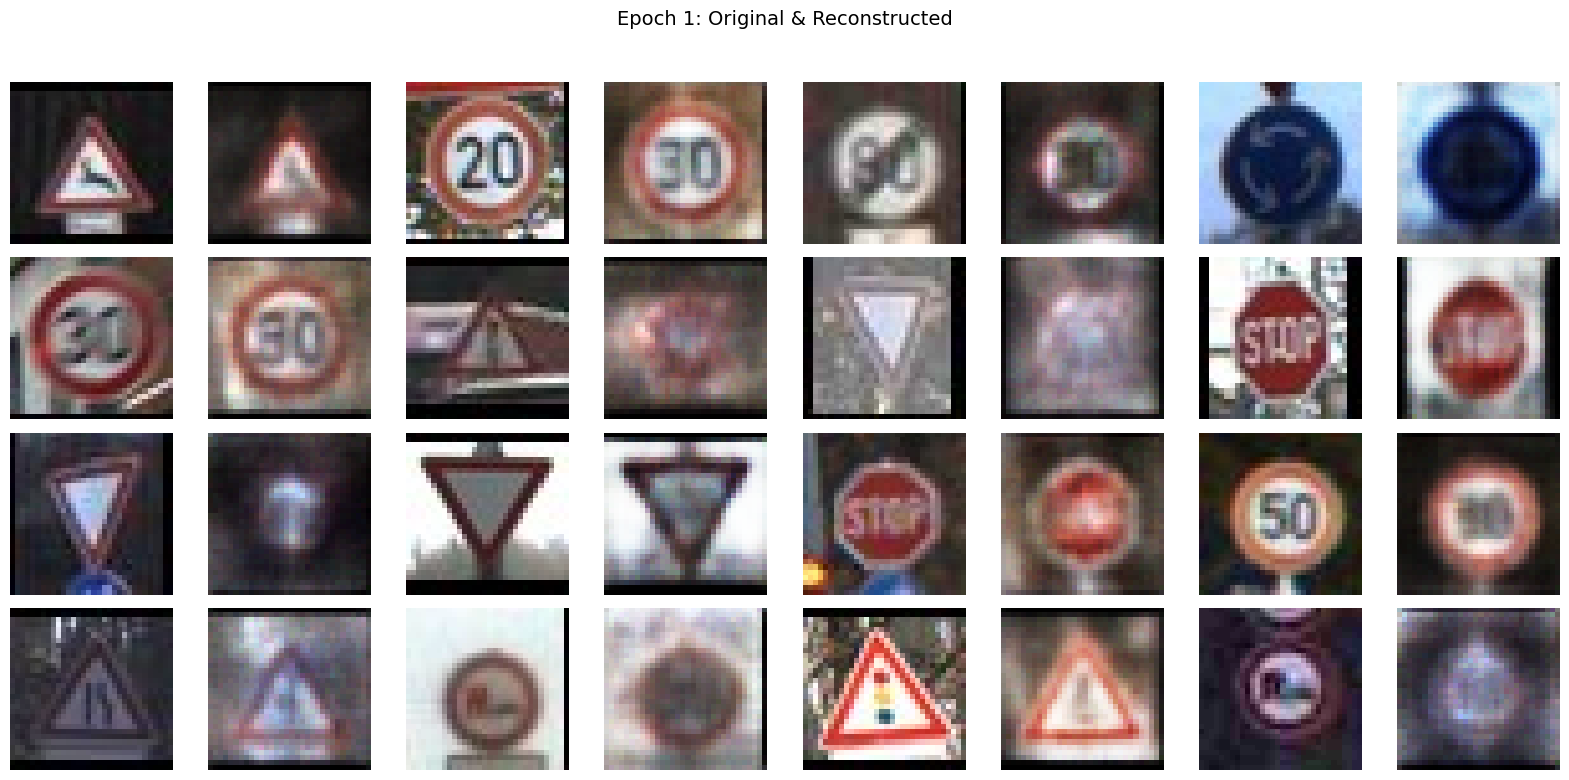

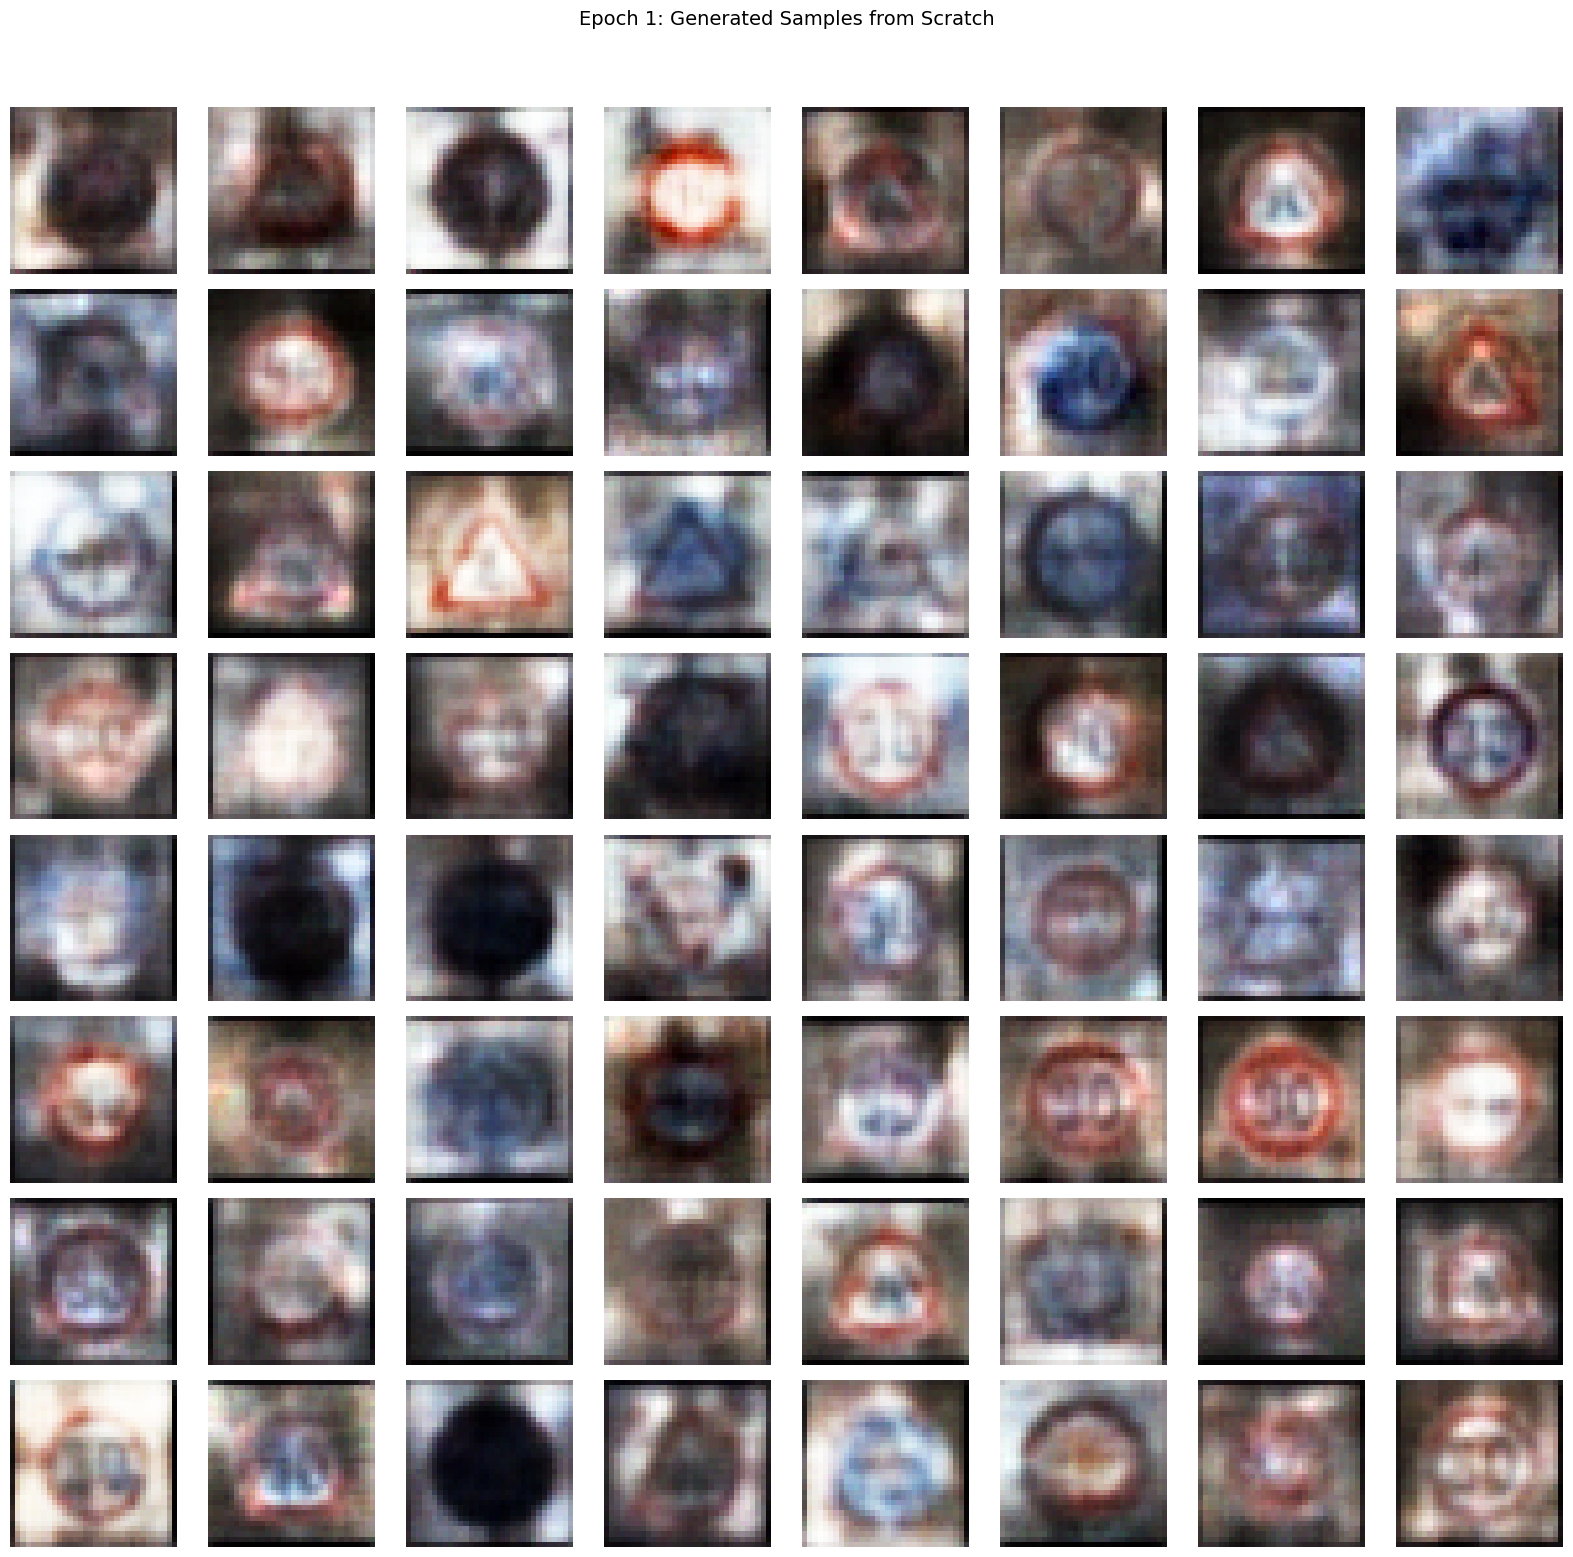

{'total_losses': [156.62973996294224],
 'reconstruction_losses': [115.43230980973902],
 'kld_losses': [41.1974303547929]}

In [9]:
vae_trainer.fit(train_dl, num_epochs=1)